In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

import pennylane as qml
n_qubits = 4
n_layers=6
weight_shapes = {"weights": (n_layers, n_qubits)}

dev = qml.device("default.qubit", wires=n_qubits)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def quantum_net(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    exp_val=[qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return tuple(exp_val)
qnode=qml.QNode(quantum_net,dev,interface='torch')
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
qlayer

<Quantum Torch Layer: func=quantum_net>

(<Figure size 500x500 with 1 Axes>, <Axes: >)

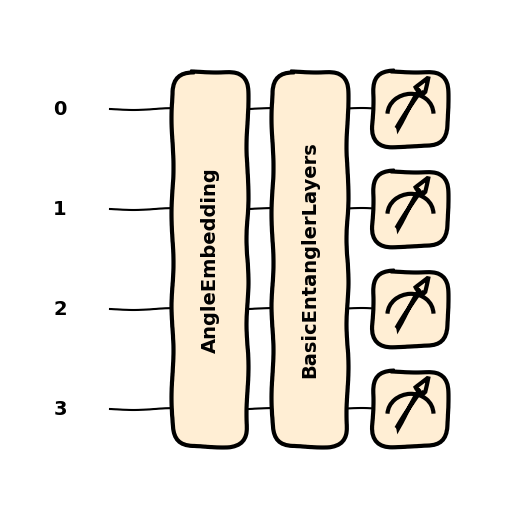

In [2]:
qml.draw_mpl(qnode,style='sketch')([0.26,0.28,3.31,0.85],torch.randn(6,4))

In [3]:
# READ DATA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

data=pd.read_csv('16.GOOG.csv')
print(data.shape)
data.head(5)

(3809, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [4]:
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
3804,2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1219.000000,1404100
3805,2019-10-01,1219.000000,1231.229980,1203.579956,1205.099976,1205.099976,1273500
3806,2019-10-02,1196.979980,1196.979980,1171.290039,1176.630005,1176.630005,1615100
3807,2019-10-03,1180.000000,1189.060059,1162.430054,1187.829956,1187.829956,1621200
3808,2019-10-04,1191.890015,1211.439941,1189.170044,1209.000000,1209.000000,1162400


In [5]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [6]:
# TRAIN TEST SPLITTING
data_training=data[data['Date']<'2019-01-01'].copy()
print(data_training.shape)
data_training.head(5)

(3617, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [7]:
data_test=data[data['Date']>='2019-01-01'].copy()
print(data_test.shape)
data_test.head(5)

(192, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
3617,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
3618,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
3619,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3620,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
3621,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900


In [8]:
training_data=data_training.drop(['Date','Adj Close'],axis=1)
# testing_data=data_test.drop(['Date','Adj Close'],axis=1)
print(training_data.shape)

(3617, 5)


In [9]:
# DATA SCALING
scaler=MinMaxScaler()
training_data=scaler.fit_transform(training_data)
print(training_data.shape)
print(training_data[0])

(3617, 5)
[3.30294890e-04 9.44785459e-04 0.00000000e+00 1.34908021e-04
 5.43577404e-01]


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# MAKING THE SEQUENCE: USING LOOK BACK PERIOD OF 60
seq_length=60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train=[]
Y_train=[]

for i in range(seq_length,training_data.shape[0]):
    X_train.append(training_data[i-seq_length:i])
    #STOCK PRICE AT THE 40TH DAY
    Y_train.append(training_data[i,0])

# converting into numpy arrays
X_train,Y_train=np.array(X_train),np.array(Y_train)
Y_train=Y_train.reshape(-1,1)
print(X_train.shape,Y_train.shape)

X_train = Variable(torch.Tensor(X_train))
Y_train = Variable(torch.Tensor(Y_train))
print(X_train.shape,Y_train.shape)


(3557, 60, 5) (3557, 1)
torch.Size([3557, 60, 5]) torch.Size([3557, 1])


In [12]:
# X_train[0]

In [13]:
# DEFINE THE LSTM NETWORK:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size,hidden_size2, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.seq_length = seq_length

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size2,
                            num_layers=num_layers, batch_first=True)

        qnode=qml.QNode(quantum_net,dev,interface='torch')
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

        self.fc = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        h_0=torch.randn(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c_0=torch.randn(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Propagate input through LSTM1
        output, (h_n,c_n) = self.lstm1(x, (h_0, c_0))

        # h_2=torch.randn(self.num_layers, x.size(0), self.hidden_size2).requires_grad_()
        h_2 = h_n # for same number of 2 lstms hidden size
        # c_2=torch.randn(self.num_layers, x.size(0), self.hidden_size2).requires_grad_()
        c_2 = c_n # for same number of 2 lstms hidden size
        # Propagate input through LSTM1
        output, (h_n,c_n) = self.lstm2(output, (h_2, c_2))

        q_in = output[:,-1,:]
        q_in=(q_in)*np.pi/2
        q_out=torch.Tensor(0,n_qubits)
        # q_out=q_out.to(device)
        for elem in q_in:
          q_out_elem = self.qlayer(elem).float().unsqueeze(0)
          q_out = torch.cat((q_out, q_out_elem))

        q_out=q_out.view(-1,n_qubits)

        out = self.fc(q_out)

        return out

num_epochs = 500
learning_rate = 0.01
input_size = 5
hidden_size = 4
hidden_size2= 4
num_layers = 1
num_classes = 1
# model
lstm = LSTM(num_classes, input_size, hidden_size, hidden_size2,num_layers)
print(lstm)

LSTM(
  (lstm1): LSTM(5, 4, batch_first=True)
  (lstm2): LSTM(4, 4, batch_first=True)
  (qlayer): <Quantum Torch Layer: func=quantum_net>
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


In [14]:
# DEFINE OPTIMIZER
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [ ]:
# TRAIN THE MODEL:
for epoch in range(num_epochs):
    outputs = lstm(X_train)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, Y_train)

    loss.backward()

    optimizer.step()
    #if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.22855


In [ ]:
# TESTING WITH TEST DATA : add last 60 data from train to test set
past_60_days=data_training.tail(60)
df=past_60_days.append(data_test,ignore_index=True)
df=df.drop(['Date','Adj Close'],axis=1)
print(df.shape)

(252, 5)


<ipython-input-17-4c41a5a0f769>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=past_60_days.append(data_test,ignore_index=True)


In [ ]:
inputs=scaler.transform(df)
inputs

array([[0.93805611, 0.93755773, 0.92220906, 0.91781776, 0.0266752 ],
       [0.91527437, 0.91792904, 0.91350452, 0.90892169, 0.01425359],
       [0.90103881, 0.91343268, 0.89872289, 0.90204445, 0.02331778],
       ...,
       [0.93940683, 0.93712442, 0.93529076, 0.9247443 , 0.01947328],
       [0.92550693, 0.93064972, 0.92791493, 0.9339358 , 0.01954719],
       [0.93524016, 0.94894575, 0.95017564, 0.95130949, 0.01398824]])

In [ ]:
# MAKING THE SEQUENCE: USING LOOK BACK PERIOD OF 60
# seq_length=60
X_test=[]
Y_test=[]

for i in range(seq_length,inputs.shape[0]):
    X_test.append(inputs[i-seq_length:i])
    #STOCK PRICE AT THE 60TH DAY
    Y_test.append(inputs[i,0])

# converting into numpy arrays
X_test,Y_test=np.array(X_test),np.array(Y_test)
Y_test=Y_test.reshape(-1,1)
print(X_test.shape,Y_test.shape)

X_test = Variable(torch.Tensor(X_test))
Y_test = Variable(torch.Tensor(Y_test))
print(X_test.shape,Y_test.shape)

# print(X_test[0])

(192, 60, 5) (192, 1)
torch.Size([192, 60, 5]) torch.Size([192, 1])


In [ ]:
# INVERSE SCALING
scaler.scale_

array([8.18605127e-04, 8.17521128e-04, 8.32487534e-04, 8.20673293e-04,
       1.21162775e-08])

torch.Size([192, 1])


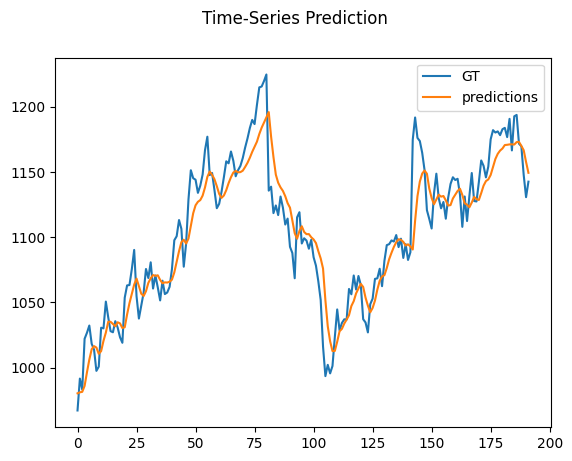

In [ ]:
# EVALUATING MODEL
Y_pred=lstm(X_test)
print(Y_pred.shape)
Y_pred=Y_pred.data.numpy()
Y_test=Y_test.data.numpy()

# inverse transform
Y_pred = Y_pred*(1/8.18605127e-04)
Y_test = Y_test*(1/8.18605127e-04)

# plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of GT used')

plt.plot(Y_test, label='GT')
plt.plot(Y_pred, label='predictions')
plt.suptitle('Time-Series Prediction')
plt.legend();
plt.show()

In [ ]:
Y_pred

array([[ 980.29065],
       [ 981.0554 ],
       [ 981.4462 ],
       [ 985.982  ],
       [ 996.40173],
       [1006.1495 ],
       [1014.0823 ],
       [1016.467  ],
       [1015.3861 ],
       [1010.5746 ],
       [1012.6251 ],
       [1020.4932 ],
       [1026.8246 ],
       [1035.0968 ],
       [1035.1199 ],
       [1033.4475 ],
       [1031.6482 ],
       [1034.7416 ],
       [1033.8859 ],
       [1030.3374 ],
       [1030.929  ],
       [1040.7456 ],
       [1049.3625 ],
       [1056.3539 ],
       [1063.5828 ],
       [1068.2103 ],
       [1062.547  ],
       [1056.6395 ],
       [1054.8541 ],
       [1058.5399 ],
       [1064.9197 ],
       [1068.4159 ],
       [1070.9135 ],
       [1070.307  ],
       [1070.7322 ],
       [1067.1522 ],
       [1064.6155 ],
       [1065.308  ],
       [1065.1725 ],
       [1065.8049 ],
       [1067.3977 ],
       [1072.9626 ],
       [1081.1537 ],
       [1089.2301 ],
       [1096.1616 ],
       [1098.0072 ],
       [1095.0536 ],
       [1098.

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test.flatten(),Y_pred.flatten())

15.95275

In [ ]:
torch.save(lstm.state_dict(),'/content/drive/MyDrive/BishowQml/hybrid_Qlstm_GoogStockPricePrediction.pth')

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test.flatten(),Y_pred.flatten())

15.95275